In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

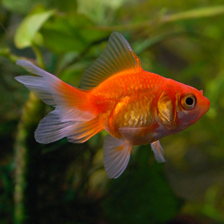

In [7]:
gold_fish = Image.open("gold_fish.png").resize(IMAGE_SHAPE)
gold_fish

In [9]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [12]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1001)

In [13]:
result

array([[ 0.22101465,  2.04749   ,  9.622565  , ..., -1.4621594 ,
        -0.28146553, -0.2598469 ]], dtype=float32)

In [14]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [15]:
 tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

24576/10484 [======================================================================] - 0s 0us/step


'C:\\Users\\hp\\.keras\\datasets\\ImageNetLabels.txt'

In [16]:
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [17]:
image_labels[predicted_label_index]

'goldfish'

In [18]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)


228827136/228813984 [==============================] - 28s 0us/step


In [19]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir


WindowsPath('datasets/flower_photos')

In [20]:
list(data_dir.glob('*/*jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [21]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


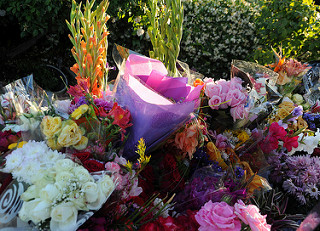

In [25]:
roses = list(data_dir.glob('roses/*'))
roses[:5]
Image.open(str(roses[3]))

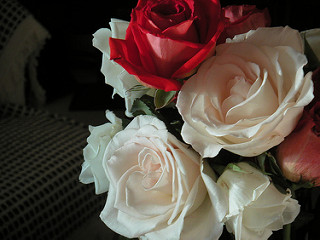

In [27]:
Image.open(str(roses[1]))

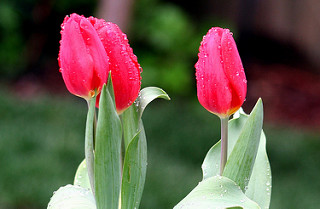

In [28]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

In [29]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [30]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [31]:
flowers_images_dict['roses'][:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

In [32]:
str(flowers_images_dict['roses'][0])

'datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

In [33]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [34]:
img.shape

(240, 179, 3)

In [41]:
cv2.resize(img,IMAGE_SHAPE).shape

(224, 224, 3)

In [42]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMAGE_SHAPE)
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [44]:
X = np.array(X)
y = np.array(y)

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [46]:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

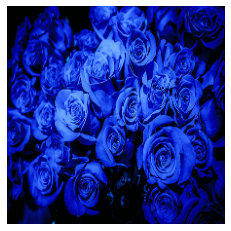

In [39]:
plt.axis('off')
plt.imshow(X[2])

In [50]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [51]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 61s 586ms/step - loss: 0.8277 - acc: 0.6959
Epoch 2/5
86/86 [==============================] - 44s 513ms/step - loss: 0.4133 - acc: 0.8630
Epoch 3/5
86/86 [==============================] - 45s 524ms/step - loss: 0.3235 - acc: 0.8939
Epoch 4/5
86/86 [==============================] - 48s 560ms/step - loss: 0.2682 - acc: 0.9150
Epoch 5/5
 3/86 [>.............................] - ETA: 43s - loss: 0.2229 - acc: 0.9583

In [ ]:
model.evaluate(X_test_scaled,y_test)